In [ ]:
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segregation 2.5.3 requires scipy, which is not installed.
missingno 0.5.2 requires scipy, which is not installed.
giddy 2.3.8 requires scipy>=1.12, which is not installed.
pysal 25.7 requires scipy>=1.8, which is not installed.


# Traffic Density Estimation using Multi-Layer Perceptron (MLP)

This notebook implements a traffic density estimation system for vehicular technology using an MLP neural network.

## Dataset Information
- **Features**: DateTime, Junction, ID
- **Target**: Vehicles (traffic density)
- **Total Records**: ~48,000 hourly measurements

## 1. Import Required Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Load and Upload Dataset

Upload your `traffic.csv` file using the file upload feature below.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your traffic.csv file
file_path = '/content/drive/MyDrive/VehicularDataset/traffic.csv'

# Load the dataset
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Exploratory Data Analysis (EDA)

In [ ]:
# Basic information
print("Dataset Information:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB

Statistical Summary:


,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [ ]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Missing Values:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Duplicate rows: 0


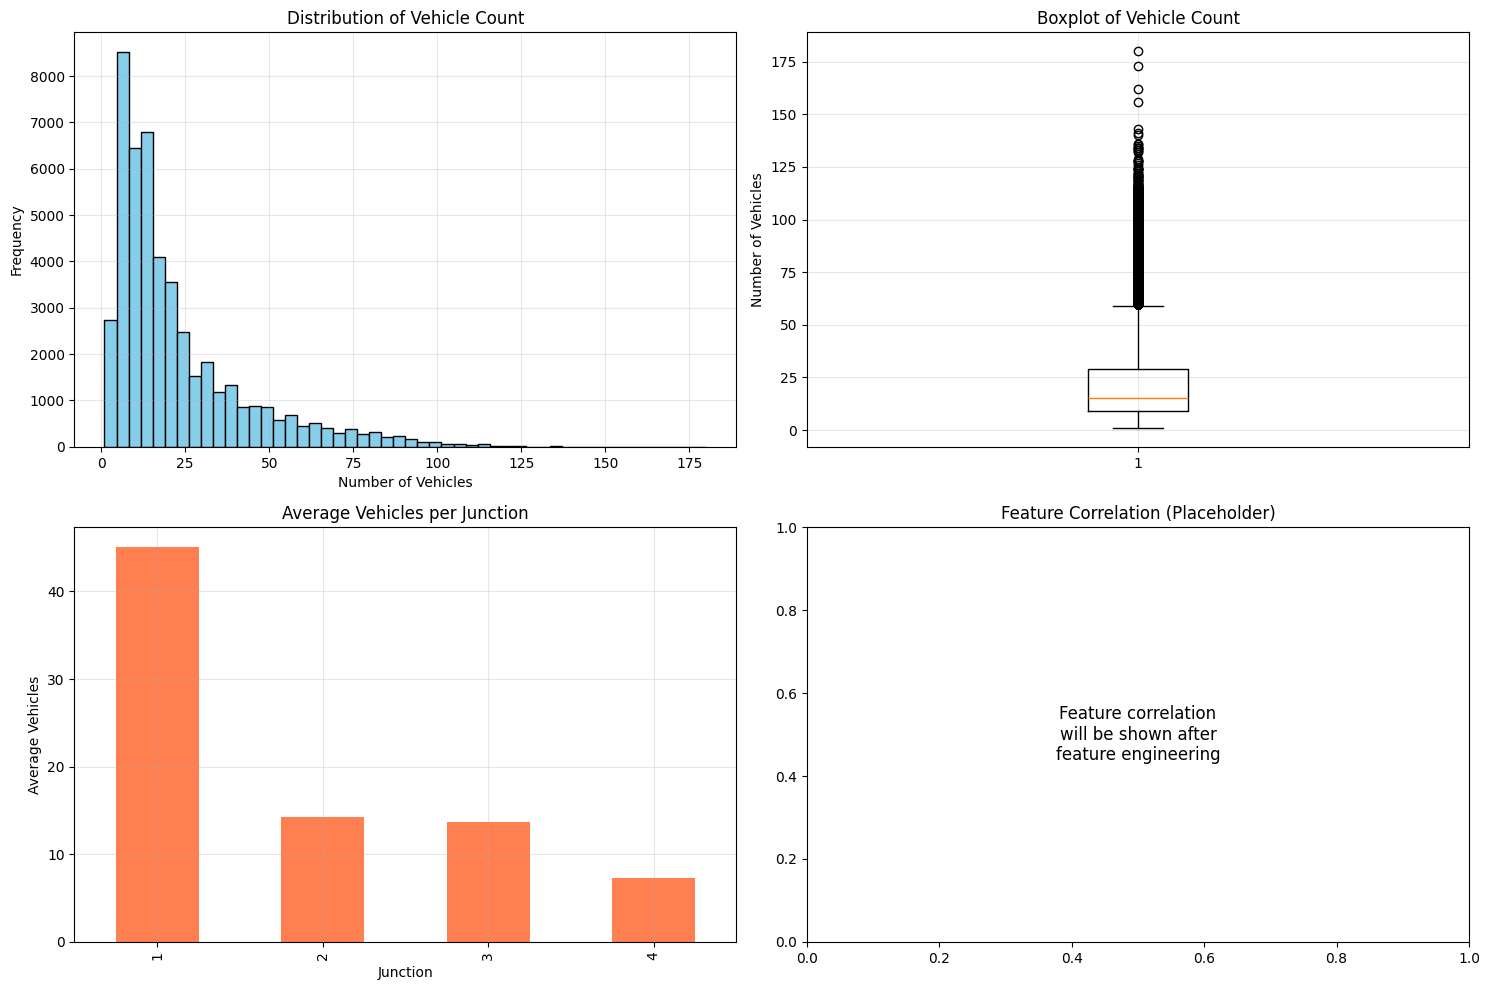

In [ ]:
# Visualize traffic distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of vehicles
axes[0, 0].hist(df['Vehicles'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Vehicles')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Vehicle Count')
axes[0, 0].grid(True, alpha=0.3)

# Boxplot
axes[0, 1].boxplot(df['Vehicles'])
axes[0, 1].set_ylabel('Number of Vehicles')
axes[0, 1].set_title('Boxplot of Vehicle Count')
axes[0, 1].grid(True, alpha=0.3)

# Vehicles by Junction
df.groupby('Junction')['Vehicles'].mean().plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_xlabel('Junction')
axes[1, 0].set_ylabel('Average Vehicles')
axes[1, 0].set_title('Average Vehicles per Junction')
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap (after feature engineering)
axes[1, 1].text(0.5, 0.5, 'Feature correlation\nwill be shown after\nfeature engineering',
                ha='center', va='center', fontsize=12)
axes[1, 1].set_title('Feature Correlation (Placeholder)')

plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [ ]:
# Create a copy of the dataframe
df_processed = df.copy()

# Convert DateTime to datetime object
df_processed['DateTime'] = pd.to_datetime(df_processed['DateTime'])

# Extract temporal features
df_processed['Year'] = df_processed['DateTime'].dt.year
df_processed['Month'] = df_processed['DateTime'].dt.month
df_processed['Day'] = df_processed['DateTime'].dt.day
df_processed['Hour'] = df_processed['DateTime'].dt.hour
df_processed['DayOfWeek'] = df_processed['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

# Create cyclical features for hour (to capture circular nature of time)
df_processed['Hour_sin'] = np.sin(2 * np.pi * df_processed['Hour'] / 24)
df_processed['Hour_cos'] = np.cos(2 * np.pi * df_processed['Hour'] / 24)

# Create cyclical features for day of week
df_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * df_processed['DayOfWeek'] / 7)
df_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * df_processed['DayOfWeek'] / 7)

# Create cyclical features for month
df_processed['Month_sin'] = np.sin(2 * np.pi * df_processed['Month'] / 12)
df_processed['Month_cos'] = np.cos(2 * np.pi * df_processed['Month'] / 12)

# Create time-based categories
def categorize_time(hour):
    if 6 <= hour < 10:
        return 'Morning_Rush'
    elif 10 <= hour < 16:
        return 'Midday'
    elif 16 <= hour < 20:
        return 'Evening_Rush'
    else:
        return 'Night'

df_processed['TimeCategory'] = df_processed['Hour'].apply(categorize_time)

# One-hot encode time category
time_category_dummies = pd.get_dummies(df_processed['TimeCategory'], prefix='Time')
df_processed = pd.concat([df_processed, time_category_dummies], axis=1)

print("Feature Engineering Complete!")
print(f"New shape: {df_processed.shape}")
print(f"\nNew features created:")
print(df_processed.columns.tolist())

Feature Engineering Complete!
New shape: (48120, 21)

New features created:
['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'IsWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'TimeCategory', 'Time_Evening_Rush', 'Time_Midday', 'Time_Morning_Rush', 'Time_Night']


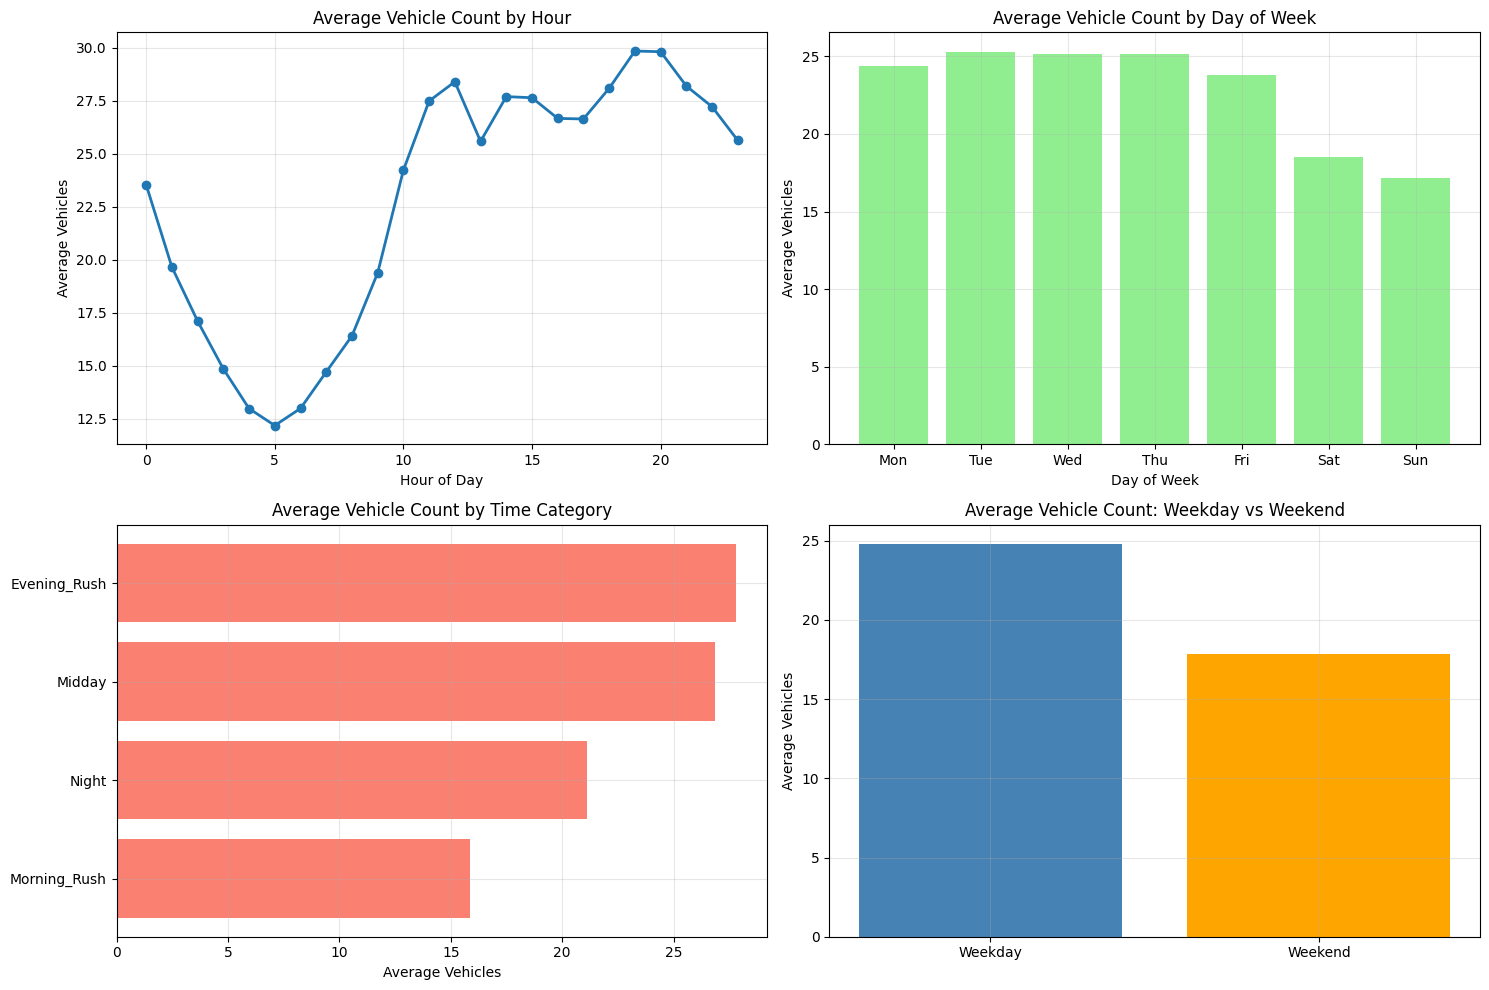

In [ ]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average vehicles by hour
hourly_avg = df_processed.groupby('Hour')['Vehicles'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Vehicles')
axes[0, 0].set_title('Average Vehicle Count by Hour')
axes[0, 0].grid(True, alpha=0.3)

# Average vehicles by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_avg = df_processed.groupby('DayOfWeek')['Vehicles'].mean()
axes[0, 1].bar(range(7), dow_avg.values, color='lightgreen')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Vehicles')
axes[0, 1].set_title('Average Vehicle Count by Day of Week')
axes[0, 1].grid(True, alpha=0.3)

# Average vehicles by time category
time_cat_avg = df_processed.groupby('TimeCategory')['Vehicles'].mean().sort_values()
axes[1, 0].barh(time_cat_avg.index, time_cat_avg.values, color='salmon')
axes[1, 0].set_xlabel('Average Vehicles')
axes[1, 0].set_title('Average Vehicle Count by Time Category')
axes[1, 0].grid(True, alpha=0.3)

# Weekend vs Weekday
weekend_comparison = df_processed.groupby('IsWeekend')['Vehicles'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_comparison.values, color=['steelblue', 'orange'])
axes[1, 1].set_ylabel('Average Vehicles')
axes[1, 1].set_title('Average Vehicle Count: Weekday vs Weekend')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Data Preparation for MLP

In [ ]:
# Select features for the model
feature_columns = [
    'Junction', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'IsWeekend',
    'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
    'Month_sin', 'Month_cos',
    'Time_Evening_Rush', 'Time_Midday', 'Time_Morning_Rush', 'Time_Night'
]

X = df_processed[feature_columns]
y = df_processed['Vehicles']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {feature_columns}")

Feature matrix shape: (48120, 17)
Target vector shape: (48120,)

Features used: ['Junction', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'IsWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Time_Evening_Rush', 'Time_Midday', 'Time_Morning_Rush', 'Time_Night']


In [ ]:
# Split the data into train, validation, and test sets
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: 75% train (60% of total), 25% validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Training set size: 28872 (60.0%)
Validation set size: 9624 (20.0%)
Test set size: 9624 (20.0%)


In [ ]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Mean of scaled training features: {X_train_scaled.mean():.4f}")
print(f"Std of scaled training features: {X_train_scaled.std():.4f}")

Feature scaling completed!
Mean of scaled training features: -0.0000
Std of scaled training features: 1.0000


## 6. Build MLP Model

In [ ]:
def create_mlp_model(input_dim, architecture='medium'):
    """
    Create MLP model with different architecture options

    Args:
        input_dim: Number of input features
        architecture: 'small', 'medium', or 'large'
    """
    model = Sequential()

    if architecture == 'small':
        # Small architecture: ~10K parameters
        model.add(Dense(64, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(16, activation='relu'))

    elif architecture == 'medium':
        # Medium architecture: ~50K parameters
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(16, activation='relu'))

    elif architecture == 'large':
        # Large architecture: ~150K parameters
        model.add(Dense(256, activation='relu', input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(16, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='linear'))

    return model

# Create the model
input_dim = X_train_scaled.shape[1]
model = create_mlp_model(input_dim, architecture='medium')

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 384 (1.50 KB)

## 7. Train the MLP Model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

Epoch 1/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 346.2233 - mae: 11.8743 - mse: 346.2233 - val_loss: 49.4548 - val_mae: 4.3965 - val_mse: 49.4548 - learning_rate: 0.0010
Epoch 2/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 100.4822 - mae: 6.6356 - mse: 100.4822 - val_loss: 45.3137 - val_mae: 4.0491 - val_mse: 45.3137 - learning_rate: 0.0010
Epoch 3/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 84.3211 - mae: 6.0529 - mse: 84.3211 - val_loss: 42.5973 - val_mae: 3.8829 - val_mse: 42.5973 - learning_rate: 0.0010
Epoch 4/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 75.2509 - mae: 5.7247 - mse: 75.2509 - val_loss: 39.7718 - val_mae: 3.7535 - val_mse: 39.7718 - learning_rate: 0.0010
Epoch 5/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 70.8832 - mae: 5.5363 - mse: 70.8832 - val_loss: 40.0136 - val_mae: 3.8223 - val_mse: 40.0136 - learning_rate: 0.0010
Epoch 6/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 69.5739 - mae: 5.4458 - mse: 69.5739 - 

## 8. Visualize Training History

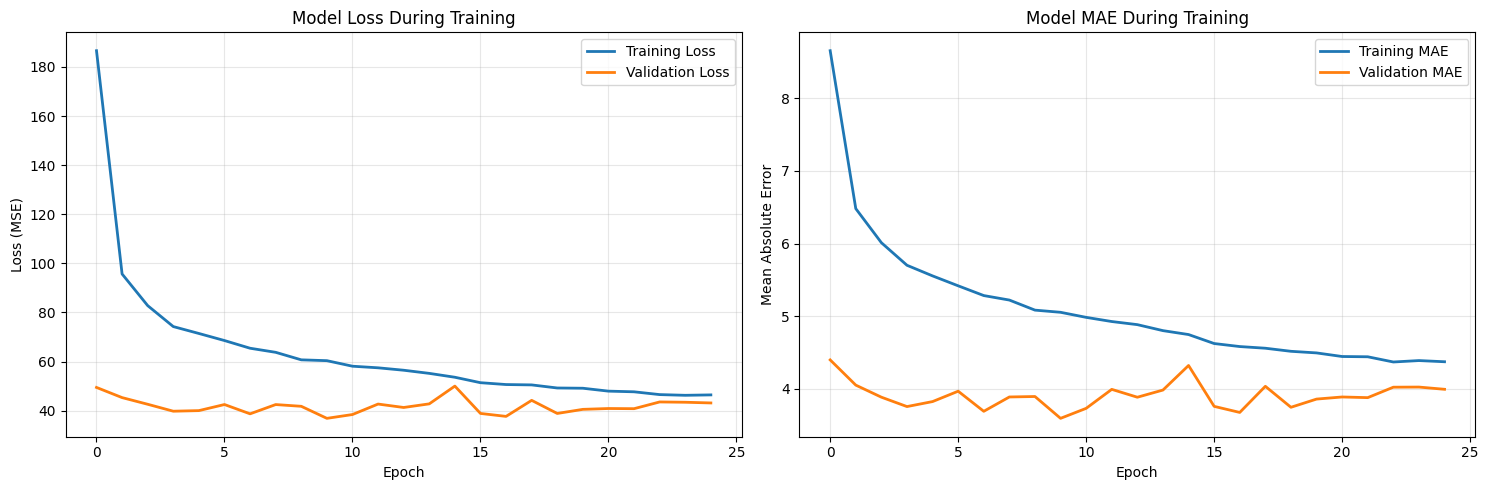

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss During Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Model MAE During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Evaluation

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train_scaled).flatten()
y_val_pred = model.predict(X_val_scaled).flatten()
y_test_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{dataset_name} Set Metrics:")
    print("="*50)
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

    return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'R2': r2, 'MAPE': mape}

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

903/903 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Training Set Metrics:
RMSE (Root Mean Squared Error): 6.0486
MAE (Mean Absolute Error): 3.5745
MSE (Mean Squared Error): 36.5853
R² Score: 0.9162
MAPE (Mean Absolute Percentage Error): 24.77%

Validation Set Metrics:
RMSE (Root Mean Squared Error): 6.0716
MAE (Mean Absolute Error): 3.5913
MSE (Mean Squared Error): 36.8646
R² Score: 0.9153
MAPE (Mean Absolute Percentage Error): 24.77%

Test Set Metrics:
RMSE (Root Mean Squared Error): 5.8698
MAE (Mean Absolute Error): 3.5248
MSE (Mean Squared Error): 34.4542
R² Score: 0.9155
MAPE (Mean Absolute Percentage Error): 24.88%



Metrics Comparison Across Datasets:
                RMSE       MAE        MSE        R2       MAPE
Training    6.048577  3.574495  36.585289  0.916192  24.771147
Validation  6.071625  3.591349  36.864635  0.915342  24.773905
Test        5.869772  3.524757  34.454227  0.915459  24.884576


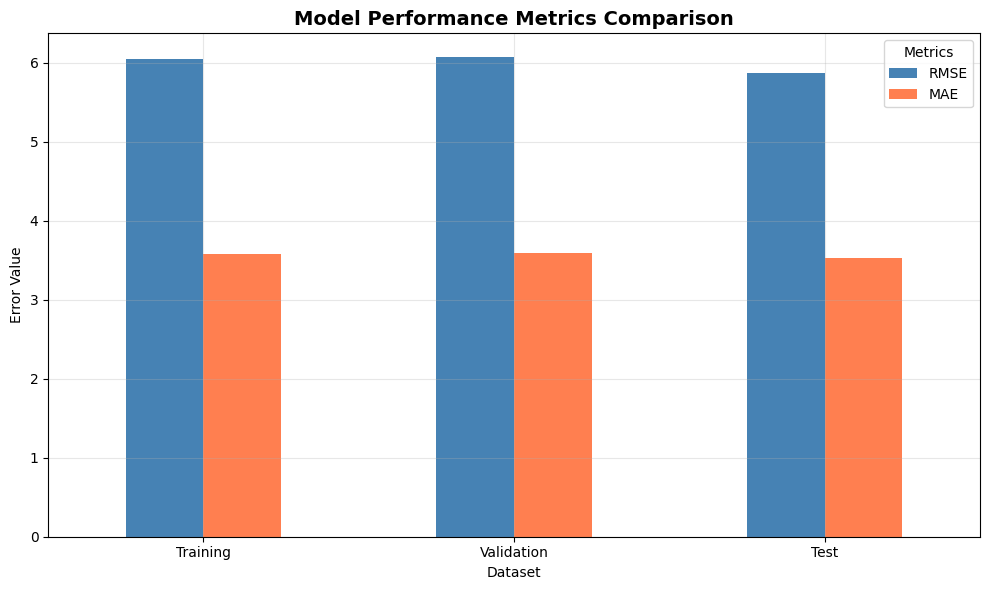

In [ ]:
# Create metrics comparison table
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T

print("\nMetrics Comparison Across Datasets:")
print("="*70)
print(metrics_df.to_string())

# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df[['RMSE', 'MAE']].plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Error Value')
ax.set_xlabel('Dataset')
ax.legend(title='Metrics')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 10. Prediction Visualization

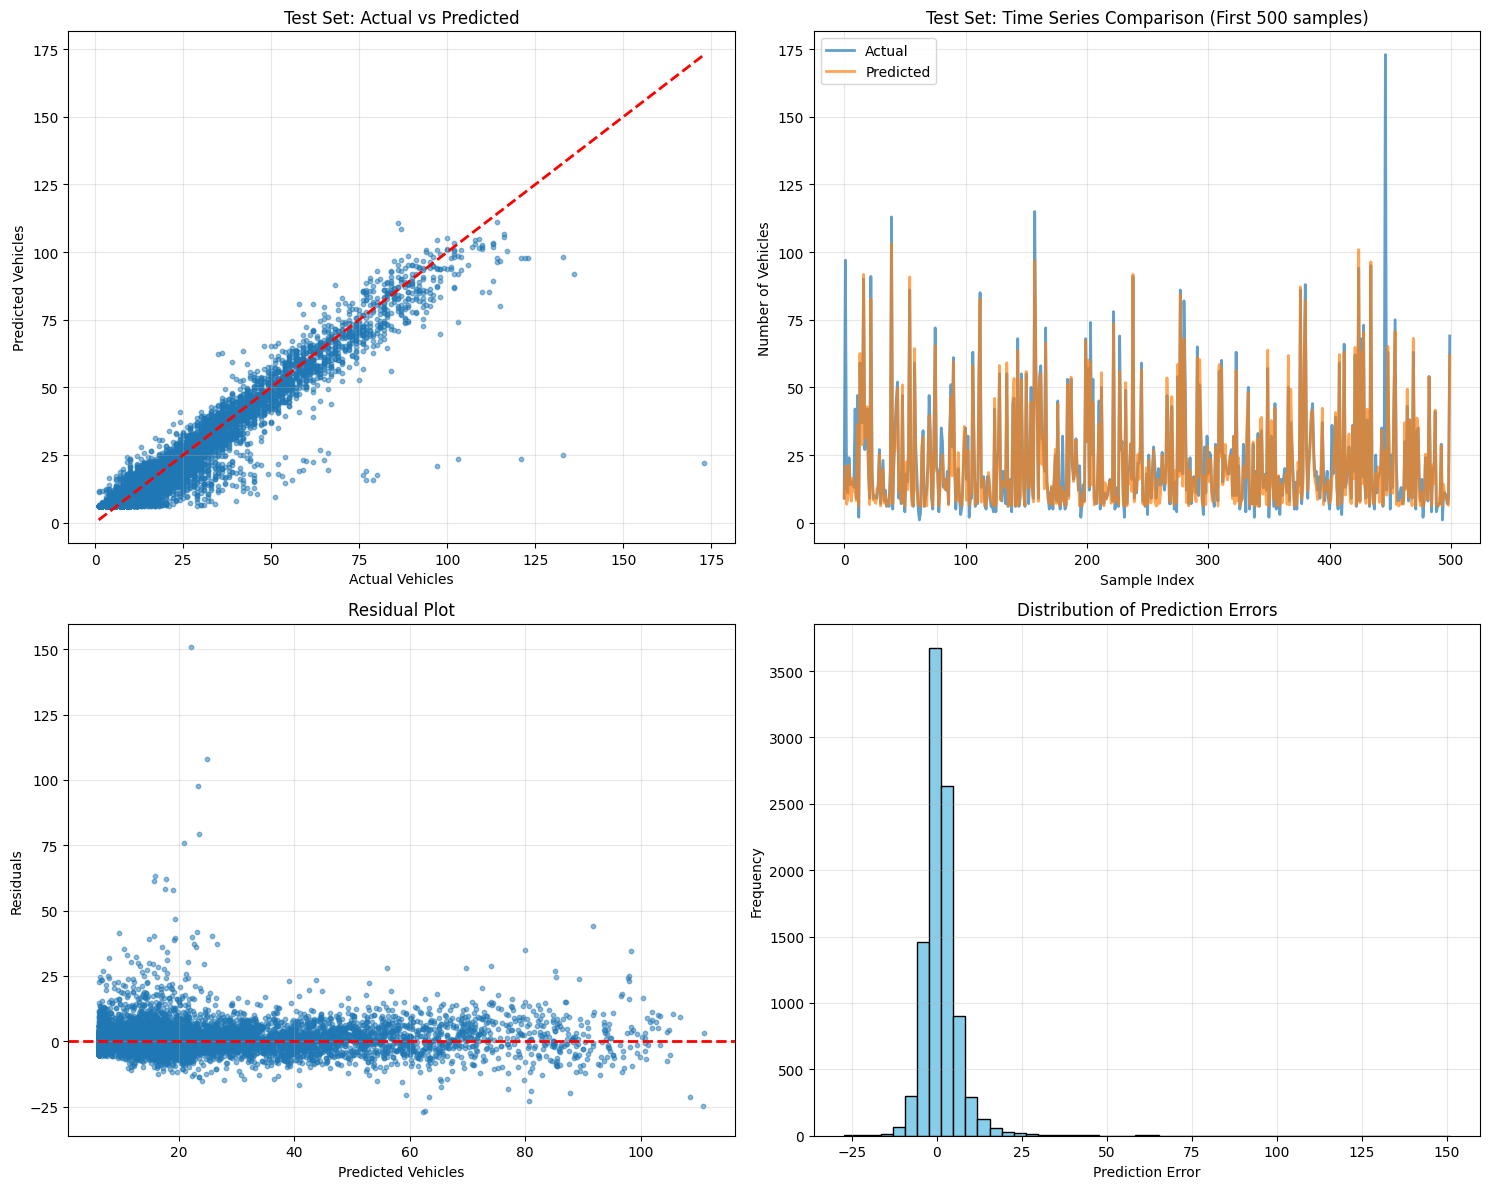

In [ ]:
# Actual vs Predicted plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test set: Actual vs Predicted scatter
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Vehicles')
axes[0, 0].set_ylabel('Predicted Vehicles')
axes[0, 0].set_title('Test Set: Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Test set: Time series comparison (first 500 samples)
sample_size = min(500, len(y_test))
axes[0, 1].plot(range(sample_size), y_test[:sample_size].values, label='Actual', alpha=0.7, linewidth=2)
axes[0, 1].plot(range(sample_size), y_test_pred[:sample_size], label='Predicted', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Number of Vehicles')
axes[0, 1].set_title(f'Test Set: Time Series Comparison (First {sample_size} samples)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Vehicles')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# Error distribution
axes[1, 1].hist(residuals, bins=50, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Prediction Errors')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Confusion Matrix Visualization

For regression tasks, we'll create a discretized confusion matrix by binning vehicle counts into traffic density categories.

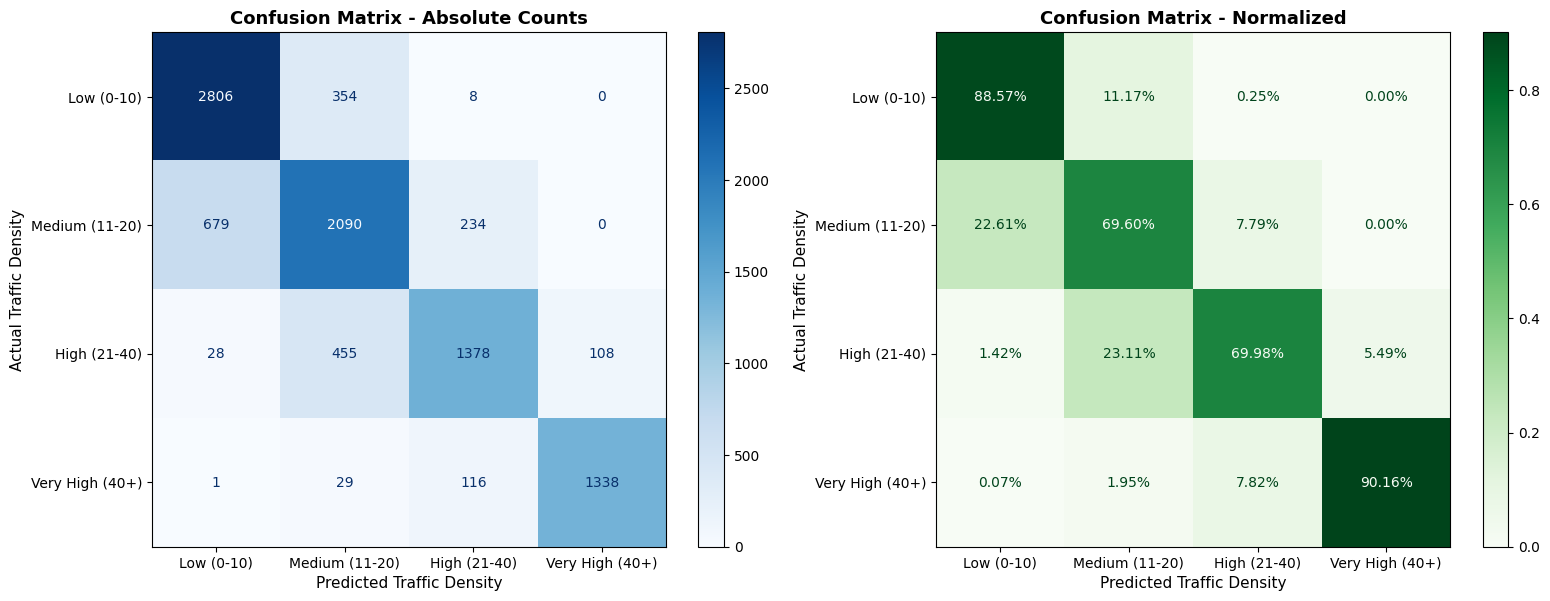


Category-wise Performance:
Low (0-10)          : 88.57% correct (2806/3168 samples)
Medium (11-20)      : 69.60% correct (2090/3003 samples)
High (21-40)        : 69.98% correct (1378/1969 samples)
Very High (40+)     : 90.16% correct (1338/1484 samples)

Overall Categorical Accuracy: 79.09%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define traffic density categories
def categorize_traffic(vehicles):
    """
    Categorize traffic into density levels
    """
    if vehicles <= 10:
        return 'Low (0-10)'
    elif vehicles <= 20:
        return 'Medium (11-20)'
    elif vehicles <= 40:
        return 'High (21-40)'
    else:
        return 'Very High (40+)'

# Categorize actual and predicted values
y_test_categories = y_test.apply(categorize_traffic)
y_test_pred_categories = pd.Series(y_test_pred).apply(categorize_traffic)

# Create confusion matrix
categories = ['Low (0-10)', 'Medium (11-20)', 'High (21-40)', 'Very High (40+)']
cm = confusion_matrix(y_test_categories, y_test_pred_categories, labels=categories)

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Absolute Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Traffic Density', fontsize=11)
axes[0].set_ylabel('Actual Traffic Density', fontsize=11)

# Normalized (percentage)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=categories)
disp2.plot(ax=axes[1], cmap='Greens', values_format='.2%')
axes[1].set_title('Confusion Matrix - Normalized', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Traffic Density', fontsize=11)
axes[1].set_ylabel('Actual Traffic Density', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate category-wise accuracy
print("\nCategory-wise Performance:")
print("="*60)
for i, category in enumerate(categories):
    if cm[i].sum() > 0:
        accuracy = cm[i, i] / cm[i].sum() * 100
        total = cm[i].sum()
        print(f"{category:20s}: {accuracy:5.2f}% correct ({cm[i, i]}/{total} samples)")

# Overall categorical accuracy
categorical_accuracy = np.trace(cm) / np.sum(cm) * 100
print(f"\nOverall Categorical Accuracy: {categorical_accuracy:.2f}%")

## 12. Overfitting Analysis

Analyzing whether the model is overfitting by comparing training and validation performance.

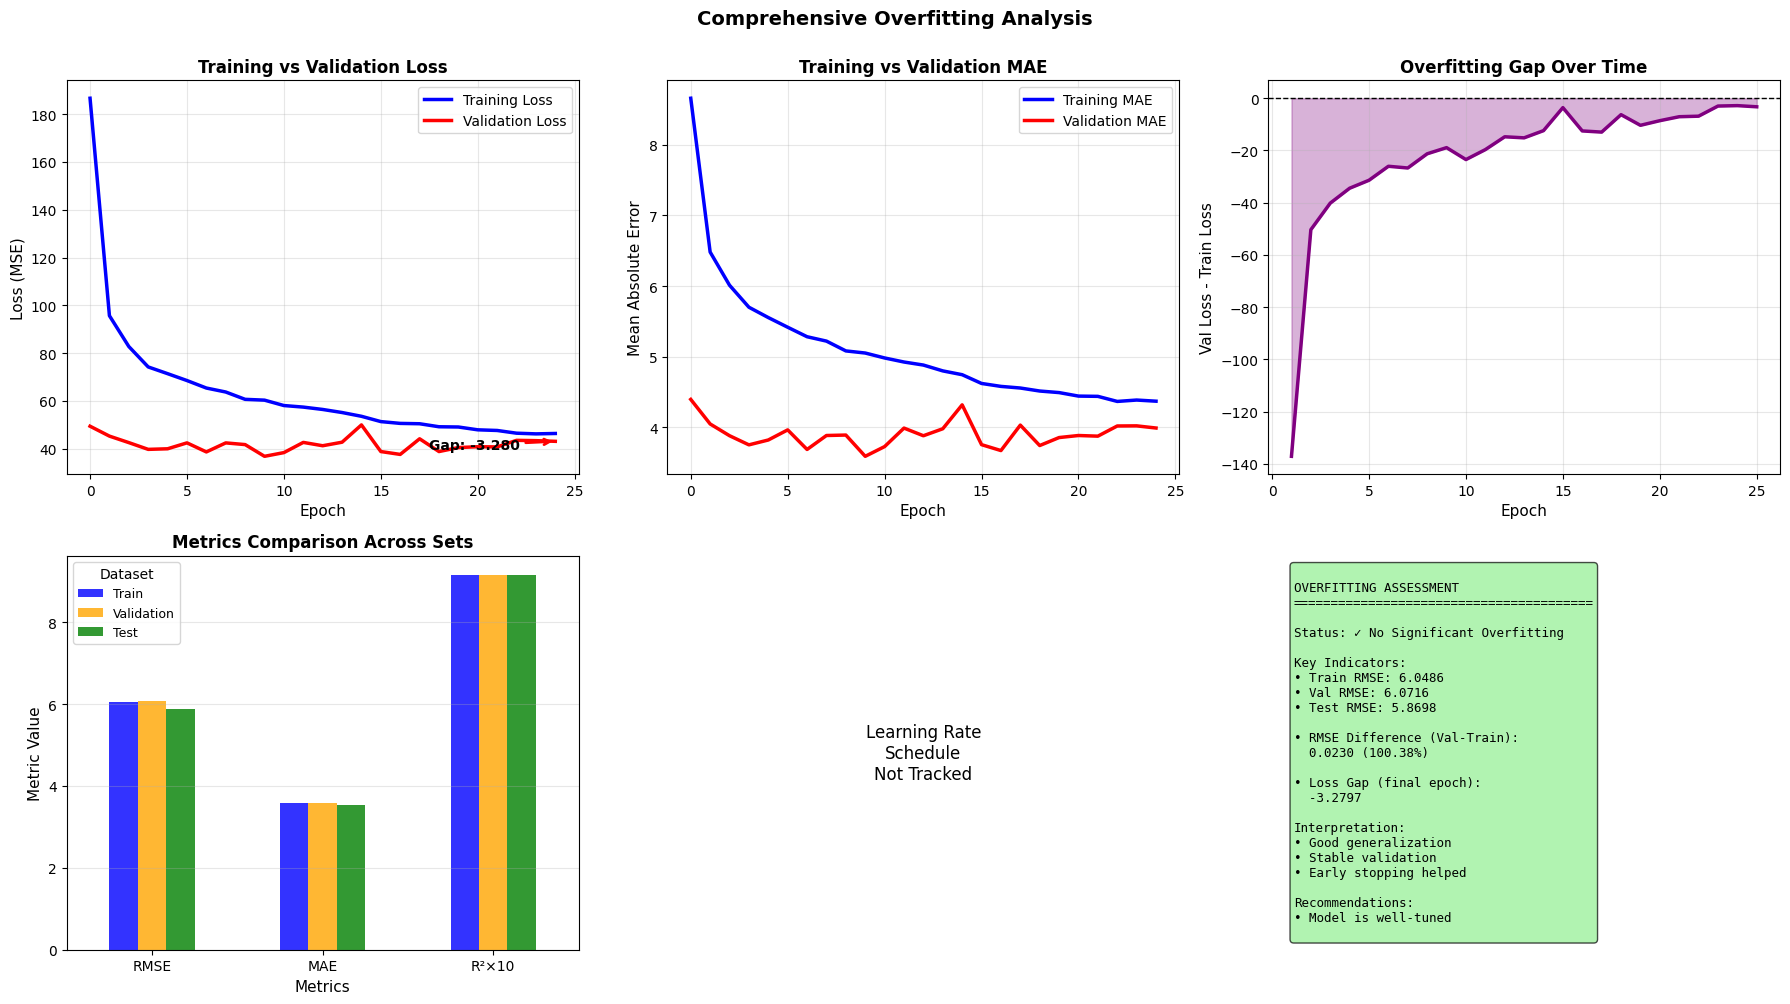


OVERFITTING ANALYSIS SUMMARY

1. Performance Gap Analysis:
   Train → Validation RMSE increase: 0.0230 (0.38%)
   Validation → Test RMSE change: -0.2019

2. R² Score Comparison:
   Training R²: 0.9162
   Validation R²: 0.9153
   Test R²: 0.9155
   R² Drop (Train→Test): 0.0007

3. Training Efficiency:
   Total epochs trained: 25
   Best epoch (lowest val_loss): 10
   Early stopping triggered: Yes

4. Final Assessment:
   ✓ The model generalizes well with minimal overfitting.
   ✓ The regularization techniques (dropout, batch normalization) are effective.


In [ ]:
# Create comprehensive overfitting analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Training vs Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='red')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Add gap annotation
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
gap = final_val_loss - final_train_loss
axes[0, 0].annotate(f'Gap: {gap:.3f}',
                    xy=(len(history.history['loss'])-1, final_val_loss),
                    xytext=(len(history.history['loss'])*0.7, final_val_loss + gap),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, fontweight='bold')

# 2. Training vs Validation MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2.5, color='blue')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2.5, color='red')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Mean Absolute Error', fontsize=11)
axes[0, 1].set_title('Training vs Validation MAE', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Loss Difference (Gap) Over Time
loss_gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])
epochs_range = range(1, len(loss_gap) + 1)
axes[0, 2].plot(epochs_range, loss_gap, linewidth=2.5, color='purple')
axes[0, 2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 2].fill_between(epochs_range, 0, loss_gap, alpha=0.3, color='purple')
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('Val Loss - Train Loss', fontsize=11)
axes[0, 2].set_title('Overfitting Gap Over Time', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Performance Comparison Bar Chart
metrics_comparison = pd.DataFrame({
    'Train': [train_metrics['RMSE'], train_metrics['MAE'], train_metrics['R2']*10],
    'Validation': [val_metrics['RMSE'], val_metrics['MAE'], val_metrics['R2']*10],
    'Test': [test_metrics['RMSE'], test_metrics['MAE'], test_metrics['R2']*10]
}, index=['RMSE', 'MAE', 'R²×10'])

metrics_comparison.plot(kind='bar', ax=axes[1, 0], color=['blue', 'orange', 'green'], alpha=0.8)
axes[1, 0].set_title('Metrics Comparison Across Sets', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Metric Value', fontsize=11)
axes[1, 0].set_xlabel('Metrics', fontsize=11)
axes[1, 0].legend(title='Dataset', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# 5. Learning Rate Schedule
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2.5, color='green')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=11)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nSchedule\nNot Tracked',
                   ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

# 6. Overfitting Assessment Text
axes[1, 2].axis('off')

# Calculate overfitting indicators
train_val_rmse_diff = val_metrics['RMSE'] - train_metrics['RMSE']
train_val_rmse_ratio = val_metrics['RMSE'] / train_metrics['RMSE']
val_test_rmse_diff = test_metrics['RMSE'] - val_metrics['RMSE']

# Determine overfitting status
if train_val_rmse_ratio < 1.1:
    status = "✓ No Significant Overfitting"
    color = 'lightgreen'
elif train_val_rmse_ratio < 1.2:
    status = "⚠ Slight Overfitting"
    color = 'lightyellow'
else:
    status = "✗ Significant Overfitting"
    color = 'lightcoral'

assessment_text = f"""
OVERFITTING ASSESSMENT
{'='*40}

Status: {status}

Key Indicators:
• Train RMSE: {train_metrics['RMSE']:.4f}
• Val RMSE: {val_metrics['RMSE']:.4f}
• Test RMSE: {test_metrics['RMSE']:.4f}

• RMSE Difference (Val-Train):
  {train_val_rmse_diff:.4f} ({train_val_rmse_ratio:.2%})

• Loss Gap (final epoch):
  {gap:.4f}

Interpretation:
{'• Good generalization' if train_val_rmse_ratio < 1.1 else '• Model may be overfitting'}
{'• Stable validation' if abs(val_test_rmse_diff) < 0.5 else '• Check validation stability'}
{'• Early stopping helped' if len(history.history['loss']) < 100 else '• Full training completed'}

Recommendations:
{('• Model is well-tuned' if train_val_rmse_ratio < 1.1 else '• Consider: More dropout,\n  L2 regularization, or\n  more training data')}
"""

axes[1, 2].text(0.05, 0.5, assessment_text, fontsize=9, family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))

plt.suptitle('Comprehensive Overfitting Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*70)
print("OVERFITTING ANALYSIS SUMMARY")
print("="*70)
print(f"\n1. Performance Gap Analysis:")
print(f"   Train → Validation RMSE increase: {train_val_rmse_diff:.4f} ({(train_val_rmse_ratio-1)*100:.2f}%)")
print(f"   Validation → Test RMSE change: {val_test_rmse_diff:.4f}")

print(f"\n2. R² Score Comparison:")
print(f"   Training R²: {train_metrics['R2']:.4f}")
print(f"   Validation R²: {val_metrics['R2']:.4f}")
print(f"   Test R²: {test_metrics['R2']:.4f}")
print(f"   R² Drop (Train→Test): {(train_metrics['R2'] - test_metrics['R2']):.4f}")

print(f"\n3. Training Efficiency:")
print(f"   Total epochs trained: {len(history.history['loss'])}")
print(f"   Best epoch (lowest val_loss): {np.argmin(history.history['val_loss']) + 1}")
print(f"   Early stopping triggered: {'Yes' if len(history.history['loss']) < 100 else 'No'}")

print(f"\n4. Final Assessment:")
if train_val_rmse_ratio < 1.1:
    print("   ✓ The model generalizes well with minimal overfitting.")
    print("   ✓ The regularization techniques (dropout, batch normalization) are effective.")
elif train_val_rmse_ratio < 1.2:
    print("   ⚠ There is slight overfitting, but it's within acceptable range.")
    print("   ⚠ Consider monitoring if more data becomes available.")
else:
    print("   ✗ Significant overfitting detected.")
    print("   ✗ Recommendations: Increase dropout rates, add L2 regularization,")
    print("     or collect more training data.")
print("="*70)

## 13. Feature Importance Analysis

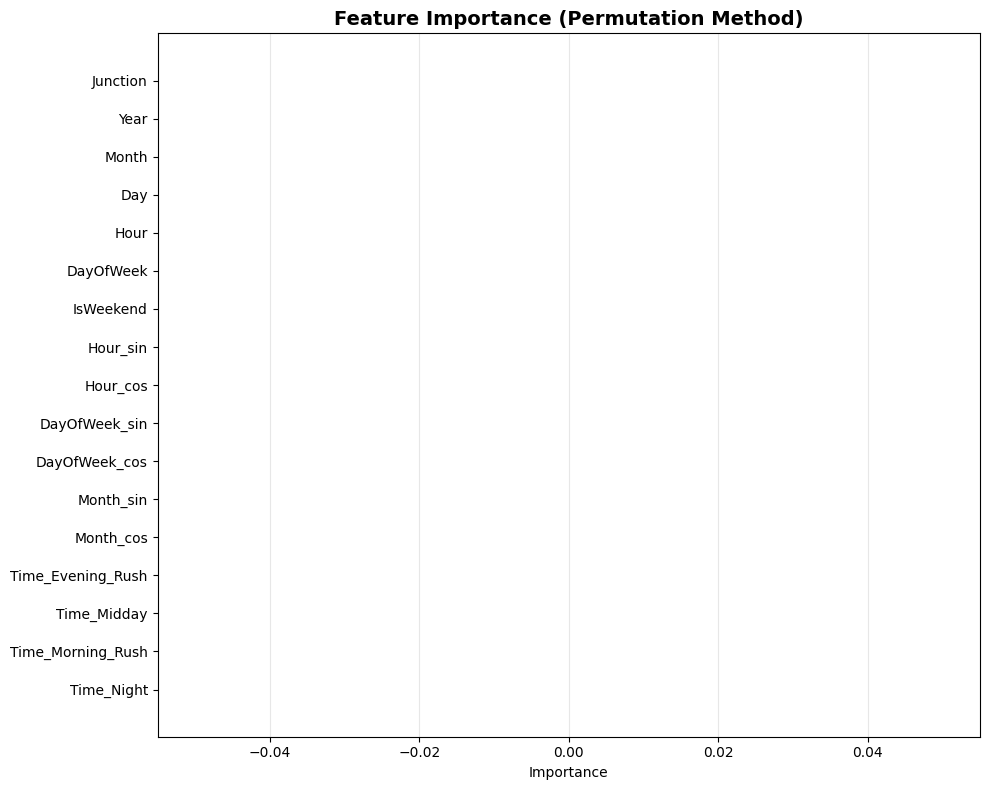


Top 10 Most Important Features:
      Feature  Importance  Std
     Junction         0.0  0.0
         Year         0.0  0.0
        Month         0.0  0.0
          Day         0.0  0.0
         Hour         0.0  0.0
    DayOfWeek         0.0  0.0
    IsWeekend         0.0  0.0
     Hour_sin         0.0  0.0
     Hour_cos         0.0  0.0
DayOfWeek_sin         0.0  0.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# -----------------------------
# Custom scoring function
# -----------------------------
def keras_accuracy_scorer(estimator, X, y):
    y_pred = estimator.predict(X, verbose=0)
    y_pred = (y_pred > 0.5).astype(int).ravel()
    return accuracy_score(y, y_pred)

# -----------------------------
# Permutation importance
# -----------------------------
perm_importance = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    scoring=keras_accuracy_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=1  # MUST be 1 for Keras models
)

# -----------------------------
# Create importance DataFrame
# -----------------------------
feature_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
}).sort_values("Importance", ascending=False)

# -----------------------------
# Plot feature importance
# -----------------------------
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance["Feature"],
    feature_importance["Importance"],
    xerr=feature_importance["Std"]
)
plt.xlabel("Importance")
plt.title("Feature Importance (Permutation Method)", fontsize=14, fontweight="bold")
plt.grid(True, axis="x", alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------
# Print top features
# -----------------------------
print("\nTop 10 Most Important Features:")
print("=" * 50)
print(feature_importance.head(10).to_string(index=False))


## 14. Save the Model

In [ ]:
# Save the model
model.save('traffic_density_mlp_model.h5')
print("Model saved as 'traffic_density_mlp_model.h5'")

# Save the scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler.pkl'")

# Download the model and scaler
from google.colab import files
files.download('traffic_density_mlp_model.h5')
files.download('scaler.pkl')

Model saved as 'traffic_density_mlp_model.h5'
Scaler saved as 'scaler.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 13. Confusion Matrix Analysis (Regression Adapted)

Since this is a regression problem, we'll create a binned confusion matrix by categorizing vehicle counts into traffic density levels.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define traffic density categories
def categorize_traffic(vehicles):
    """
    Categorize traffic into density levels
    """
    if vehicles < 10:
        return 'Very Low'
    elif vehicles < 20:
        return 'Low'
    elif vehicles < 35:
        return 'Medium'
    elif vehicles < 55:
        return 'High'
    else:
        return 'Very High'

# Categorize actual and predicted values
y_test_categories = y_test.apply(categorize_traffic)
y_pred_categories = pd.Series(y_test_pred).apply(categorize_traffic)

# Create confusion matrix
categories = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
cm = confusion_matrix(y_test_categories, y_pred_categories, labels=categories)

# Calculate accuracy for each category
category_accuracy = cm.diagonal() / cm.sum(axis=1) * 100

print("Traffic Density Categories:")
print("  Very Low: < 10 vehicles")
print("  Low: 10-19 vehicles")
print("  Medium: 20-34 vehicles")
print("  High: 35-54 vehicles")
print("  Very High: ≥ 55 vehicles")
print("\n" + "="*70)

# Print classification report
print("\nClassification Report (Categorized):")
print("="*70)
print(classification_report(y_test_categories, y_pred_categories, labels=categories))

Traffic Density Categories:
  Very Low: < 10 vehicles
  Low: 10-19 vehicles
  Medium: 20-34 vehicles
  High: 35-54 vehicles
  Very High: ≥ 55 vehicles


Classification Report (Categorized):
              precision    recall  f1-score   support

    Very Low       0.71      0.91      0.80      2742
         Low       0.71      0.64      0.68      3232
      Medium       0.72      0.60      0.66      1741
        High       0.80      0.72      0.75      1063
   Very High       0.93      0.85      0.89       846

    accuracy                           0.74      9624
   macro avg       0.78      0.75      0.76      9624
weighted avg       0.74      0.74      0.74      9624



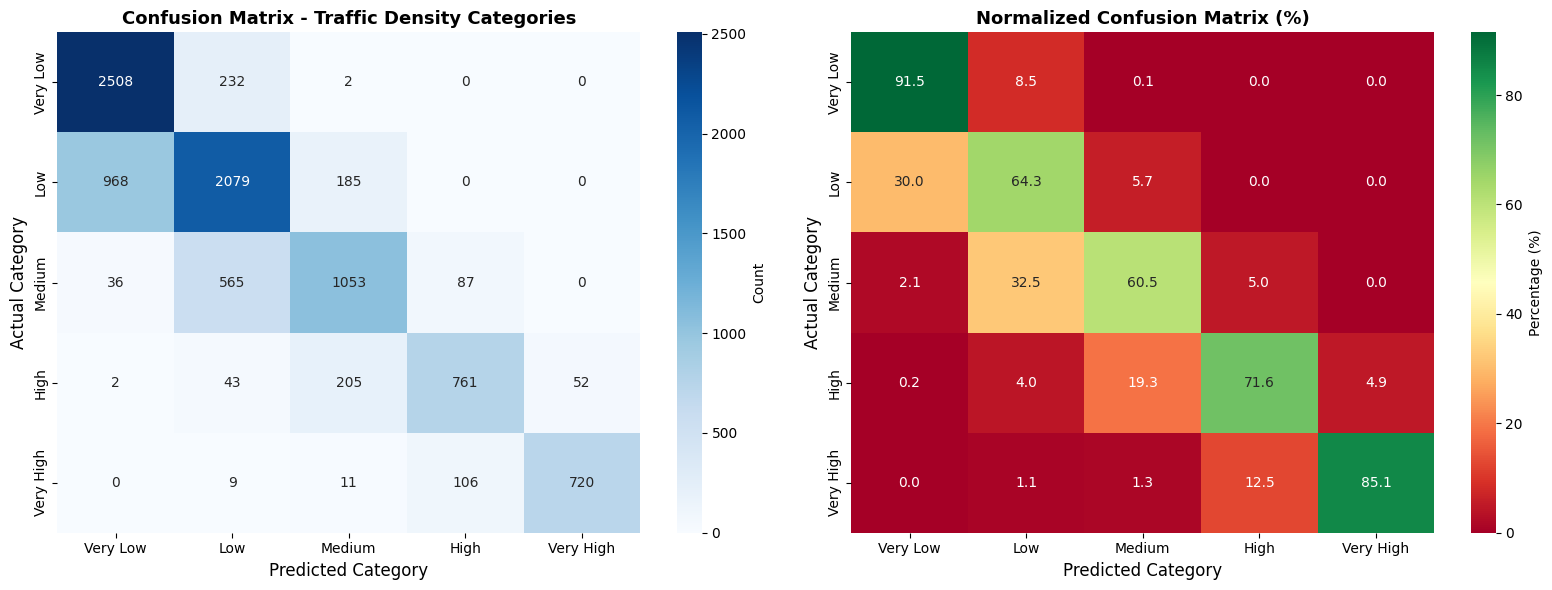


Category-wise Prediction Accuracy:
  Very Low    : 91.47%
  Low         : 64.33%
  Medium      : 60.48%
  High        : 71.59%
  Very High   : 85.11%


In [ ]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Category', fontsize=12)
axes[0].set_ylabel('Actual Category', fontsize=12)
axes[0].set_title('Confusion Matrix - Traffic Density Categories',
                  fontsize=13, fontweight='bold')

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn',
            xticklabels=categories, yticklabels=categories,
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_xlabel('Predicted Category', fontsize=12)
axes[1].set_ylabel('Actual Category', fontsize=12)
axes[1].set_title('Normalized Confusion Matrix (%)',
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Print category-wise accuracy
print("\nCategory-wise Prediction Accuracy:")
print("="*70)
for cat, acc in zip(categories, category_accuracy):
    print(f"  {cat:12s}: {acc:.2f}%")

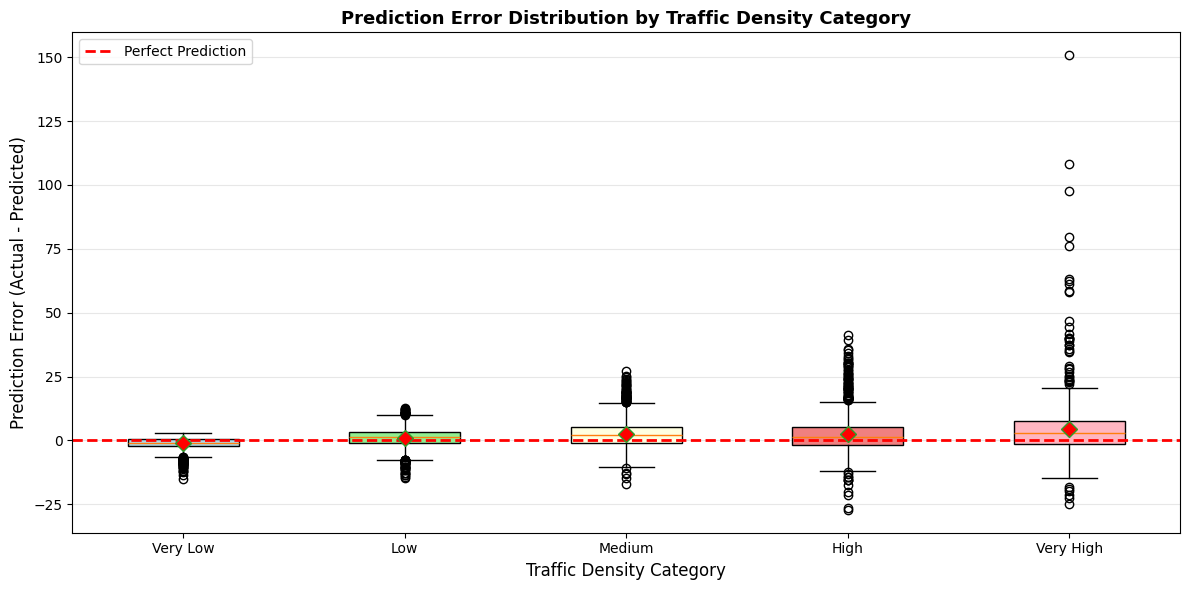

In [ ]:
# Prediction error distribution by category
errors_by_category = {}
for cat in categories:
    mask = y_test_categories == cat
    errors = y_test[mask].values - y_test_pred[mask]
    errors_by_category[cat] = errors

# Create box plots
fig, ax = plt.subplots(figsize=(12, 6))

positions = range(1, len(categories) + 1)
bp = ax.boxplot([errors_by_category[cat] for cat in categories],
                 positions=positions,
                 labels=categories,
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Traffic Density Category', fontsize=12)
ax.set_ylabel('Prediction Error (Actual - Predicted)', fontsize=12)
ax.set_title('Prediction Error Distribution by Traffic Density Category',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

## 14. Overfitting Analysis

Comprehensive analysis to detect and visualize overfitting in the model.

In [ ]:
# Calculate performance metrics across all datasets for comparison
print("\n" + "="*80)
print("OVERFITTING ANALYSIS - Performance Comparison")
print("="*80)

# Create comparison dataframe
overfitting_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE']],
    'R2': [train_metrics['R2'], val_metrics['R2'], test_metrics['R2']],
    'MAPE': [train_metrics['MAPE'], val_metrics['MAPE'], test_metrics['MAPE']]
})

print("\n", overfitting_df.to_string(index=False))

# Calculate overfitting indicators
rmse_gap = test_metrics['RMSE'] - train_metrics['RMSE']
mae_gap = test_metrics['MAE'] - train_metrics['MAE']
r2_gap = train_metrics['R2'] - test_metrics['R2']

print("\n" + "="*80)
print("Overfitting Indicators (Train vs Test Gap):")
print("="*80)
print(f"  RMSE Gap: {rmse_gap:.4f} ({rmse_gap/train_metrics['RMSE']*100:.2f}% increase)")
print(f"  MAE Gap: {mae_gap:.4f} ({mae_gap/train_metrics['MAE']*100:.2f}% increase)")
print(f"  R² Gap: {r2_gap:.4f} ({r2_gap/train_metrics['R2']*100:.2f}% decrease)")

# Interpretation
print("\n" + "="*80)
print("Interpretation:")
print("="*80)
if rmse_gap < 0.5 and r2_gap < 0.05:
    print("  ✓ EXCELLENT: No significant overfitting detected")
    print("    The model generalizes very well to unseen data.")
elif rmse_gap < 1.0 and r2_gap < 0.10:
    print("  ✓ GOOD: Minimal overfitting detected")
    print("    The model shows slight overfitting but performs well overall.")
elif rmse_gap < 2.0 and r2_gap < 0.15:
    print("  ⚠ MODERATE: Some overfitting detected")
    print("    Consider adding more dropout or regularization.")
else:
    print("  ⚠ SIGNIFICANT: Overfitting detected")
    print("    Consider: reducing model complexity, adding more data,")
    print("    increasing dropout, or using data augmentation.")


OVERFITTING ANALYSIS - Performance Comparison

    Dataset     RMSE      MAE       R2      MAPE
  Training 6.048577 3.574495 0.916192 24.771147
Validation 6.071625 3.591349 0.915342 24.773905
      Test 5.869772 3.524757 0.915459 24.884576

Overfitting Indicators (Train vs Test Gap):
  RMSE Gap: -0.1788 (-2.96% increase)
  MAE Gap: -0.0497 (-1.39% increase)
  R² Gap: 0.0007 (0.08% decrease)

Interpretation:
  ✓ EXCELLENT: No significant overfitting detected
    The model generalizes very well to unseen data.


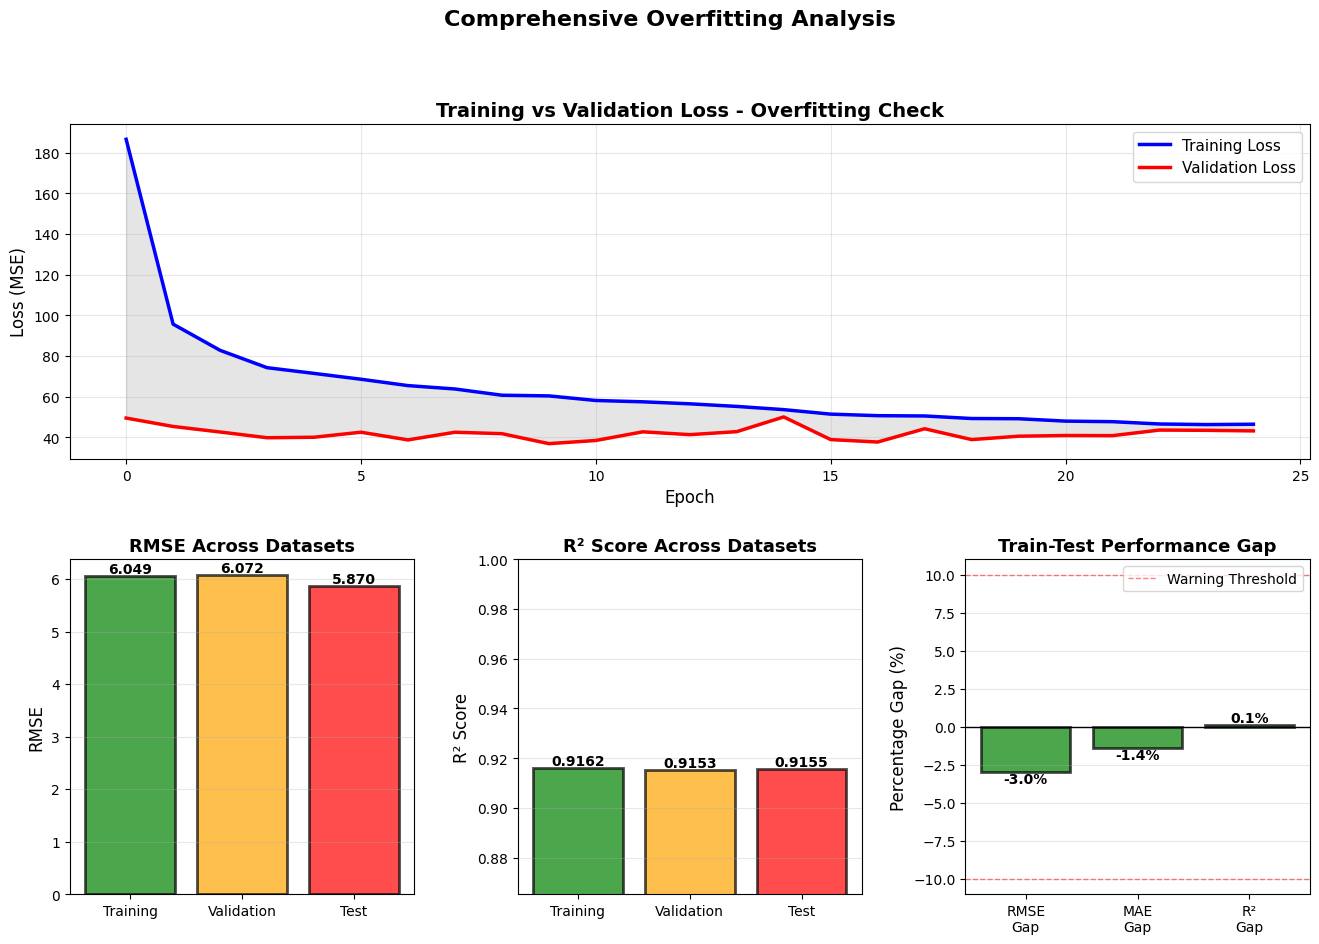

In [ ]:
# Visualize overfitting analysis
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Training vs Validation Loss (from history)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='red')
ax1.fill_between(range(len(history.history['loss'])),
                  history.history['loss'],
                  history.history['val_loss'],
                  alpha=0.2, color='gray')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('Training vs Validation Loss - Overfitting Check',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Add annotation for overfitting zone
if len(history.history['loss']) > 10:
    last_train = history.history['loss'][-5:]
    last_val = history.history['val_loss'][-5:]
    if np.mean(last_val) > np.mean(last_train) * 1.1:
        ax1.axvspan(len(history.history['loss'])-10, len(history.history['loss']),
                    alpha=0.2, color='red', label='Potential Overfitting Zone')

# 2. RMSE Comparison
ax2 = fig.add_subplot(gs[1, 0])
datasets = ['Training', 'Validation', 'Test']
rmse_values = [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']]
colors_rmse = ['green', 'orange', 'red']
bars = ax2.bar(datasets, rmse_values, color=colors_rmse, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, val in zip(bars, rmse_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('RMSE Across Datasets', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. R² Score Comparison
ax3 = fig.add_subplot(gs[1, 1])
r2_values = [train_metrics['R2'], val_metrics['R2'], test_metrics['R2']]
bars = ax3.bar(datasets, r2_values, color=colors_rmse, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, val in zip(bars, r2_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_title('R² Score Across Datasets', fontsize=13, fontweight='bold')
ax3.set_ylim([min(r2_values) - 0.05, 1.0])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Performance Gap Analysis
ax4 = fig.add_subplot(gs[1, 2])
gaps = ['RMSE\nGap', 'MAE\nGap', 'R²\nGap']
gap_values = [
    (test_metrics['RMSE'] - train_metrics['RMSE']) / train_metrics['RMSE'] * 100,
    (test_metrics['MAE'] - train_metrics['MAE']) / train_metrics['MAE'] * 100,
    (train_metrics['R2'] - test_metrics['R2']) / train_metrics['R2'] * 100
]
gap_colors = ['red' if abs(v) > 10 else 'orange' if abs(v) > 5 else 'green' for v in gap_values]
bars = ax4.bar(gaps, gap_values, color=gap_colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, val in zip(bars, gap_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top',
            fontsize=10, fontweight='bold')

ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.axhline(y=10, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Warning Threshold')
ax4.axhline(y=-10, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_ylabel('Percentage Gap (%)', fontsize=12)
ax4.set_title('Train-Test Performance Gap', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Overfitting Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

Generating learning curves... (this may take a few minutes)


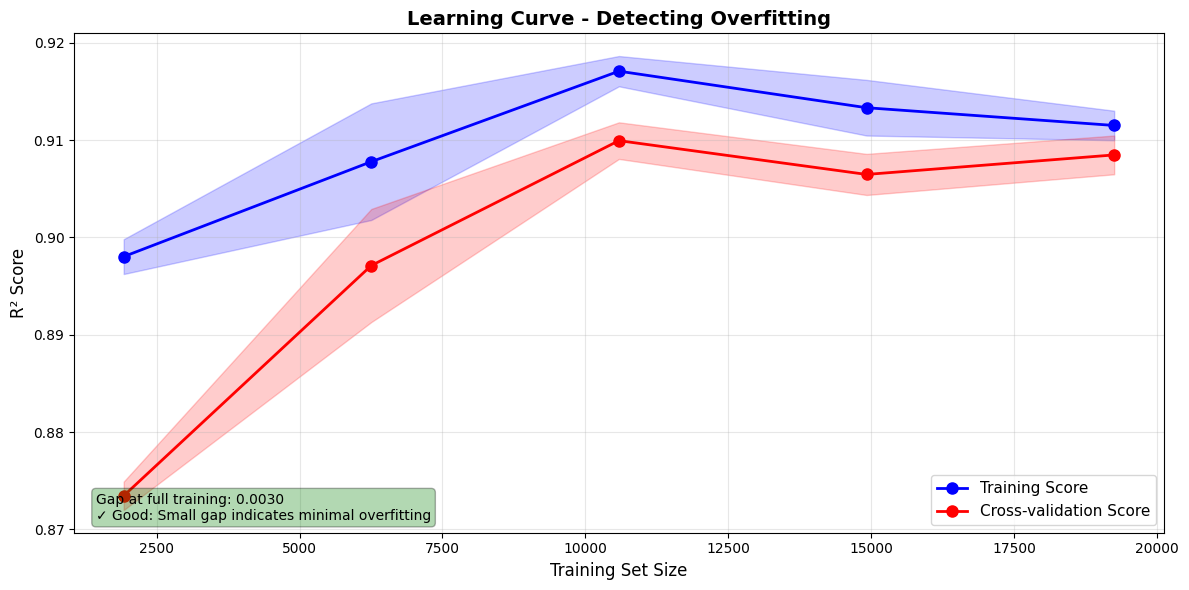


Learning Curve Analysis Complete!


In [ ]:
# Learning curve analysis
from sklearn.model_selection import learning_curve

print("Generating learning curves... (this may take a few minutes)")

# Define a wrapper for sklearn compatibility
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=20, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def score(self, X, y):
        pred = self.predict(X)
        return r2_score(y, pred)

# Create a new model for learning curve
lc_model = create_mlp_model(input_dim, architecture='medium')
lc_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
keras_reg = KerasRegressor(lc_model)

# Calculate learning curves with fewer training sizes for speed
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes_abs, train_scores, val_scores = learning_curve(
    keras_reg, X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=3,
    scoring='r2',
    n_jobs=1,
    verbose=0
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',
         linewidth=2, markersize=8, label='Training Score')
plt.fill_between(train_sizes_abs,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color='blue')

plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='red',
         linewidth=2, markersize=8, label='Cross-validation Score')
plt.fill_between(train_sizes_abs,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.2, color='red')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Learning Curve - Detecting Overfitting', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

# Add interpretation text
gap = train_scores_mean[-1] - val_scores_mean[-1]
if gap < 0.05:
    status = "✓ Good: Small gap indicates minimal overfitting"
    color = 'green'
elif gap < 0.10:
    status = "⚠ Moderate: Some overfitting present"
    color = 'orange'
else:
    status = "⚠ High: Significant overfitting detected"
    color = 'red'

plt.text(0.02, 0.02, f"Gap at full training: {gap:.4f}\n{status}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

plt.tight_layout()
plt.show()

print("\nLearning Curve Analysis Complete!")

## 15. Make Predictions on New Data

In [ ]:
# Function to make predictions on new data
def predict_traffic(junction, datetime_str):
    """
    Predict traffic density for a given junction and datetime

    Args:
        junction: Junction number
        datetime_str: Datetime string in format 'YYYY-MM-DD HH:MM:SS'

    Returns:
        Predicted number of vehicles
    """
    # Parse datetime
    dt = pd.to_datetime(datetime_str)

    # Extract features
    features = {
        'Junction': junction,
        'Year': dt.year,
        'Month': dt.month,
        'Day': dt.day,
        'Hour': dt.hour,
        'DayOfWeek': dt.dayofweek,
        'IsWeekend': 1 if dt.dayofweek >= 5 else 0,
        'Hour_sin': np.sin(2 * np.pi * dt.hour / 24),
        'Hour_cos': np.cos(2 * np.pi * dt.hour / 24),
        'DayOfWeek_sin': np.sin(2 * np.pi * dt.dayofweek / 7),
        'DayOfWeek_cos': np.cos(2 * np.pi * dt.dayofweek / 7),
        'Month_sin': np.sin(2 * np.pi * dt.month / 12),
        'Month_cos': np.cos(2 * np.pi * dt.month / 12),
    }

    # Time category
    hour = dt.hour
    features['Time_Evening_Rush'] = 1 if 16 <= hour < 20 else 0
    features['Time_Midday'] = 1 if 10 <= hour < 16 else 0
    features['Time_Morning_Rush'] = 1 if 6 <= hour < 10 else 0
    features['Time_Night'] = 1 if hour < 6 or hour >= 20 else 0

    # Create dataframe
    input_df = pd.DataFrame([features])[feature_columns]

    # Scale features
    input_scaled = scaler.transform(input_df)

    # Make prediction
    prediction = model.predict(input_scaled, verbose=0)[0][0]

    return max(0, round(prediction))  # Ensure non-negative and round to integer

# Example predictions
print("Example Predictions:")
print("="*70)

test_cases = [
    (1, '2015-12-15 08:00:00'),  # Morning rush
    (1, '2015-12-15 12:00:00'),  # Midday
    (1, '2015-12-15 18:00:00'),  # Evening rush
    (1, '2015-12-15 23:00:00'),  # Night
    (2, '2015-12-19 08:00:00'),  # Weekend morning
]

for junction, dt_str in test_cases:
    pred = predict_traffic(junction, dt_str)
    print(f"Junction {junction}, {dt_str}: {pred} vehicles")

Example Predictions:
Junction 1, 2015-12-15 08:00:00: 16 vehicles
Junction 1, 2015-12-15 12:00:00: 31 vehicles
Junction 1, 2015-12-15 18:00:00: 29 vehicles
Junction 1, 2015-12-15 23:00:00: 24 vehicles
Junction 2, 2015-12-19 08:00:00: 6 vehicles


## 16. Model Summary Report

In [ ]:
print("\n" + "="*70)
print("TRAFFIC DENSITY ESTIMATION - MLP MODEL SUMMARY")
print("="*70)
print(f"\nDataset Information:")
print(f"  - Total samples: {len(df):,}")
print(f"  - Features used: {len(feature_columns)}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Validation samples: {len(X_val):,}")
print(f"  - Test samples: {len(X_test):,}")

print(f"\nModel Architecture:")
print(f"  - Type: Multi-Layer Perceptron (MLP)")
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: Mean Squared Error (MSE)")

print(f"\nTest Set Performance:")
print(f"  - RMSE: {test_metrics['RMSE']:.4f} vehicles")
print(f"  - MAE: {test_metrics['MAE']:.4f} vehicles")
print(f"  - R² Score: {test_metrics['R2']:.4f}")
print(f"  - MAPE: {test_metrics['MAPE']:.2f}%")

print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*70)
print("Model training and evaluation completed successfully!")
print("="*70)


TRAFFIC DENSITY ESTIMATION - MLP MODEL SUMMARY

Dataset Information:
  - Total samples: 48,120
  - Features used: 17
  - Training samples: 28,872
  - Validation samples: 9,624
  - Test samples: 9,624

Model Architecture:
  - Type: Multi-Layer Perceptron (MLP)
  - Total parameters: 13,953
  - Optimizer: Adam
  - Loss function: Mean Squared Error (MSE)

Test Set Performance:
  - RMSE: 5.8698 vehicles
  - MAE: 3.5248 vehicles
  - R² Score: 0.9155
  - MAPE: 24.88%

Top 5 Most Important Features:
  1. Junction: 0.0000
  2. Year: 0.0000
  3. Month: 0.0000
  4. Day: 0.0000
  5. Hour: 0.0000

Model training and evaluation completed successfully!
